In [11]:
stocks = ['AAPL','C','COST','CVX','DIS','HON','IBM',
         'JNJ','JPM','MCD','MDT','MRK','MSFT',
          'NEE','NKE','ORCL','PEP','PFE','PG',
          'UNP','UTX','VZ','WMT','XOM','HD',
          'KO','CMCSA','SPY'
         ]
import quandl
import pandas as pd
import pytz
from collections import OrderedDict

    
quandl.ApiConfig.api_key = "uRMo697HgMj91ZZZa2_v"
data = OrderedDict()
for i in stocks:
    print(i)
    data[i] = quandl.get('EOD/{}'.format(i),start_date='1997-01-01', end_date='2009-01-25')
    data[i] = data[i][['Open','High','Low','Close','Volume']]
    data[i] = data[i].rename(columns={"Open": "open", "High": "high",'Close':"close","Low":"low","Volume":"volume"})
    print(data[i].head())
panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

AAPL
             open   high    low  close      volume
Date                                              
1997-01-02  21.12  21.25  20.75  21.00   1277800.0
1997-01-03  21.12  22.25  21.00  21.75   1068900.0
1997-01-06  17.62  18.34  17.25  17.87  16811000.0
1997-01-07  18.12  18.25  17.50  17.50   8722600.0
1997-01-08  18.25  18.37  17.37  17.62   9822600.0
C
             open   high    low  close     volume
Date                                             
1997-01-02  45.13  45.75  43.75  44.50  1578667.0
1997-01-03  45.00  45.75  44.25  45.13  1463333.0
1997-01-06  45.00  46.13  45.00  45.38  1477667.0
1997-01-07  45.13  45.13  44.25  45.00  1672333.0
1997-01-08  45.13  45.63  44.75  44.88  1450000.0
COST
             open   high    low  close     volume
Date                                             
1997-01-02  25.25  25.25  24.12  24.37  1396600.0
1997-01-03  24.25  24.25  23.75  24.12  3191800.0
1997-01-06  24.12  24.75  24.12  24.69  2393000.0
1997-01-07  24.75  25.25  24.50

             open   high    low  close     volume
Date                                             
1997-01-02  50.25  50.38  48.88  49.13  1526467.0
1997-01-03  49.50  50.25  49.38  49.75  1597800.0
1997-01-06  49.88  50.50  49.88  50.25  2251867.0
1997-01-07  50.00  51.38  49.63  51.38  2817600.0
1997-01-08  52.00  52.00  50.88  51.25  3463267.0
KO
             open   high    low  close     volume
Date                                             
1997-01-02  52.13  52.50  51.13  51.88  3580900.0
1997-01-03  52.50  53.38  52.25  53.13  2656000.0
1997-01-06  53.25  53.63  52.25  52.63  3129800.0
1997-01-07  52.13  54.38  51.88  54.38  3662700.0
1997-01-08  54.13  54.50  53.13  53.38  2856000.0
CMCSA
             open   high    low  close     volume
Date                                             
1997-01-02  17.50  17.75  17.00  17.25   612400.0
1997-01-03  17.25  17.50  17.13  17.50   502200.0
1997-01-06  17.50  17.63  17.13  17.19   574800.0
1997-01-07  17.13  17.50  17.13  17.50   

In [12]:
panel = pd.Panel(data)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 28 (items) x 3035 (major_axis) x 5 (minor_axis)
Items axis: AAPL to SPY
Major_axis axis: 1997-01-02 00:00:00 to 2009-01-23 00:00:00
Minor_axis axis: open to volume


In [13]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from zipline.api import order_target_percent, record, symbol,get_datetime,set_benchmark,order,order_percent,get_open_orders,symbols,schedule_function
from zipline.finance import commission
from zipline import run_algorithm
from zipline.utils.events import date_rules, time_rules  
import matplotlib.pyplot as plt
import numpy as np
import pytz
import pandas as pd
import datetime
import pickle
from abc import abstractmethod
from collections import defaultdict

from six import with_metaclass
from toolz import merge

from zipline.assets import Equity, Future
from zipline.finance.constants import FUTURE_EXCHANGE_FEES_BY_SYMBOL
from zipline.finance.shared import AllowedAssetMarker, FinancialModelMeta
from zipline.utils.dummy import DummyMapping

selected_stock =['AAPL','C','COST','CVX','DIS','HON','IBM',
         'JNJ','JPM','MCD','MDT','MRK','MSFT',
          'NEE','NKE','ORCL','PEP','PFE','PG',
          'UNP','UTX','VZ','WMT','XOM','HD',
          'KO','CMCSA'
         ]
# parameters 

def initialize(context):
    context.time = 0
    context.stocks = symbols('AAPL','C','COST','CVX','DIS','HON','IBM',
         'JNJ','JPM','MCD','MDT','MRK','MSFT',
          'NEE','NKE','ORCL','PEP','PFE','PG',
          'UNP','UTX','VZ','WMT','XOM','HD',
          'KO','CMCSA')
    context.max_positions = 30
    context.window = 252
    set_benchmark(symbol('SPY'))
    # 1. manually setting the commission
    context.set_commission(commission.PerTrade(cost=0.0005))

def handle_data(context, data):
    final = pd.read_csv('test3.csv')
    final["Date"]=pd.to_datetime(final["Date"])
    quandl.ApiConfig.api_key = "uRMo697HgMj91ZZZa2_v"
    ben = quandl.get('EOD/SPY'.format(i),start_date='2007-01-05', end_date='2008-12-31')
    ben['return'] = ben["Close"]/ben["Close"].shift(1) - 1
    ben = ben.reset_index()
    # 2. warm-up period
    tday=get_datetime().date()
    beg = '['
    end = ']'
    r1 = ben[ben['Date']==tday]['return'].values[0]
    if context.time == 0:
        context.time += 1
        cleaned_weights = []
        
        # extract prices
        prices = data.history(context.stocks, fields='price',
                          bar_count=context.window + 1, frequency='1d')
        # calculate expected returns and sample covariance amtrix
        avg_returns = expected_returns.mean_historical_return(prices)
        cov_mat = risk_models.sample_cov(prices)

        # get weights maximizing the Sharpe ratio
        ef = EfficientFrontier(avg_returns, cov_mat)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        print(cleaned_weights)
    # submit orders
        for asset in context.stocks:
            #order_target_percent(asset, cleaned_weights[asset])
            order_target_percent(asset, 1/len(context.stocks))
    else:
        context.time += 1
        for stock in context.stocks:
            st = str(stock)
            b = str(stock).index(beg)
            e = str(stock).index(end)
            st = st[b+1:e]
            pr = final[final["Date"]==tday][st].values[0]
            current_position = context.portfolio.positions[stock].amount
    # 5. trading logic
            if pr>0.005:
                number_stock = round(pr*current_position)
                order(stock, 0.5*number_stock)
                if number_stock >0:
                    print(tday)
                    print('buy {} in number {}'.format(st,number_stock))
            elif pr<-0.005:
                number_stock = round(pr*current_position)
                order(stock, number_stock)
                if number_stock >0:
                    print(tday)
                    print('short {} in number {}'.format(st,number_stock))
    # save values for later inspection
        record(value=context.portfolio.portfolio_value,POS=current_position,
           SPY=r1,leverage=context.account.leverage,pro_returns = context.portfolio.returns)
# 6. analyze block
def analyze(context, perf):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=[10,10])
    # portfolio value
    perf[['value']].plot(ax=ax[0])
    ax[0].set_ylabel('portfolio value in $')

    # daily returns
    perf.algorithm_period_return.plot(ax=ax[1])
    perf.benchmark_period_return.plot(ax=ax[1])
    ax[1].set_ylabel('daily returns')
    ax[1].legend()
    
    perf.leverage.plot(ax=ax[2])
    ax[2].set_ylabel('leverage')
    ax[2].legend()
    
    fig.suptitle('Simple LSTM Strategy - {}'.format(selected_stock), fontsize=16)
    plt.legend()
    plt.show()
    
    print('Final portfolio value (including cash): {}$'.format(np.round(perf.portfolio_value[-1], 2)))
    print(perf.tail())


{Equity(0 [CVX]): 0.0, Equity(1 [UNP]): 0.0, Equity(2 [PEP]): 0.0, Equity(3 [NEE]): 0.15762, Equity(4 [MRK]): 0.10762, Equity(5 [IBM]): 0.0, Equity(6 [KO]): 0.0, Equity(7 [NKE]): 0.09881, Equity(8 [DIS]): 0.1686, Equity(9 [VZ]): 0.0, Equity(10 [WMT]): 0.0, Equity(11 [HON]): 0.0, Equity(12 [MCD]): 0.00915, Equity(13 [PG]): 0.0, Equity(14 [JPM]): 0.0, Equity(16 [HD]): 0.0, Equity(17 [ORCL]): 0.07456, Equity(18 [XOM]): 0.10709, Equity(19 [PFE]): 0.0, Equity(20 [AAPL]): 0.0, Equity(21 [JNJ]): 0.0, Equity(22 [MDT]): 0.0, Equity(23 [MSFT]): 0.0, Equity(24 [C]): 0.0, Equity(25 [COST]): 0.0, Equity(26 [CMCSA]): 0.27655, Equity(27 [UTX]): 0.0}
2007-01-08
buy AAPL in number 3.0
2007-01-08
buy NKE in number 2.0
2007-01-08
buy ORCL in number 18.0
2007-01-08
buy UTX in number 3.0
2007-01-08
buy WMT in number 5.0
2007-01-09
buy AAPL in number 3.0
2007-01-09
buy NKE in number 2.0
2007-01-09
buy ORCL in number 13.0
2007-01-09
buy UTX in number 3.0
2007-01-09
buy WMT in number 5.0
2007-01-10
buy AAPL i

2007-03-28
buy AAPL in number 4.0
2007-03-28
buy PG in number 3.0
2007-03-28
buy UTX in number 5.0
2007-03-28
buy WMT in number 7.0
2007-03-28
buy KO in number 4.0
2007-03-29
buy AAPL in number 5.0
2007-03-29
buy PG in number 4.0
2007-03-29
buy UTX in number 6.0
2007-03-29
buy WMT in number 7.0
2007-03-29
buy KO in number 4.0
2007-03-30
buy AAPL in number 5.0
2007-03-30
buy IBM in number 2.0
2007-03-30
buy NKE in number 2.0
2007-03-30
buy PG in number 4.0
2007-03-30
buy UTX in number 6.0
2007-03-30
buy WMT in number 7.0
2007-03-30
buy KO in number 4.0
2007-04-02
buy AAPL in number 5.0
2007-04-02
buy IBM in number 2.0
2007-04-02
buy NKE in number 2.0
2007-04-02
buy PG in number 4.0
2007-04-02
buy UTX in number 6.0
2007-04-02
buy WMT in number 7.0
2007-04-02
buy KO in number 4.0
2007-04-03
buy AAPL in number 4.0
2007-04-03
buy IBM in number 2.0
2007-04-03
buy PG in number 5.0
2007-04-03
buy UTX in number 6.0
2007-04-03
buy WMT in number 7.0
2007-04-03
buy KO in number 4.0
2007-04-04
buy 

2007-06-25
buy HON in number 6.0
2007-06-25
buy PG in number 8.0
2007-06-25
buy UTX in number 4.0
2007-06-25
buy WMT in number 7.0
2007-06-26
buy HON in number 9.0
2007-06-26
buy PG in number 8.0
2007-06-26
buy UTX in number 5.0
2007-06-26
buy WMT in number 7.0
2007-06-27
buy HON in number 6.0
2007-06-27
buy ORCL in number 23.0
2007-06-27
buy PG in number 8.0
2007-06-27
buy UTX in number 5.0
2007-06-27
buy WMT in number 7.0
2007-06-28
buy HON in number 6.0
2007-06-28
buy ORCL in number 45.0
2007-06-28
buy PG in number 7.0
2007-06-28
buy UTX in number 5.0
2007-06-28
buy WMT in number 7.0
2007-06-29
buy HON in number 4.0
2007-06-29
buy ORCL in number 26.0
2007-06-29
buy PG in number 7.0
2007-06-29
buy UTX in number 5.0
2007-06-29
buy WMT in number 7.0
2007-07-02
buy AAPL in number 3.0
2007-07-02
buy HON in number 6.0
2007-07-02
buy PG in number 7.0
2007-07-02
buy UTX in number 5.0
2007-07-02
buy WMT in number 7.0
2007-07-03
buy AAPL in number 4.0
2007-07-03
buy HON in number 7.0
2007-07-

2007-09-21
buy AAPL in number 4.0
2007-09-21
buy HON in number 5.0
2007-09-21
buy ORCL in number 28.0
2007-09-21
buy PG in number 13.0
2007-09-21
buy UTX in number 7.0
2007-09-21
buy WMT in number 13.0
2007-09-24
buy AAPL in number 3.0
2007-09-24
buy HON in number 6.0
2007-09-24
buy ORCL in number 53.0
2007-09-24
buy PG in number 12.0
2007-09-24
buy UTX in number 7.0
2007-09-24
buy WMT in number 13.0
2007-09-25
buy PG in number 12.0
2007-09-25
buy UTX in number 7.0
2007-09-25
buy WMT in number 13.0
2007-09-26
buy HON in number 5.0
2007-09-26
buy PG in number 11.0
2007-09-26
buy UTX in number 7.0
2007-09-26
buy WMT in number 13.0
2007-09-27
buy HON in number 7.0
2007-09-27
buy PG in number 11.0
2007-09-27
buy UTX in number 7.0
2007-09-27
buy WMT in number 13.0
2007-09-28
buy HON in number 9.0
2007-09-28
buy PG in number 9.0
2007-09-28
buy UTX in number 7.0
2007-09-28
buy WMT in number 12.0
2007-10-01
buy PG in number 8.0
2007-10-01
buy UTX in number 6.0
2007-10-01
buy WMT in number 12.0

2008-01-07
buy ORCL in number 30.0
2008-01-07
buy WMT in number 9.0
2008-01-08
buy ORCL in number 30.0
2008-01-08
buy WMT in number 9.0
2008-01-09
buy ORCL in number 36.0
2008-01-09
buy WMT in number 10.0
2008-01-10
buy ORCL in number 42.0
2008-01-10
buy WMT in number 10.0
2008-01-11
buy HON in number 7.0
2008-01-11
buy ORCL in number 37.0
2008-01-11
buy WMT in number 10.0
2008-01-14
buy HON in number 5.0
2008-01-14
buy ORCL in number 36.0
2008-01-14
buy WMT in number 10.0
2008-01-15
buy HON in number 8.0
2008-01-15
buy ORCL in number 34.0
2008-01-15
buy WMT in number 10.0
2008-01-15
buy CMCSA in number 2.0
2008-01-16
buy MCD in number 5.0
2008-01-16
buy ORCL in number 24.0
2008-01-16
buy WMT in number 10.0
2008-01-16
buy CMCSA in number 2.0
2008-01-17
buy MCD in number 5.0
2008-01-17
buy ORCL in number 52.0
2008-01-17
buy WMT in number 11.0
2008-01-17
buy CMCSA in number 2.0
2008-01-18
buy MCD in number 6.0
2008-01-18
buy ORCL in number 34.0
2008-01-18
buy UTX in number 6.0
2008-01-18

2008-03-20
buy AAPL in number 3.0
2008-03-20
buy DIS in number 7.0
2008-03-20
buy ORCL in number 29.0
2008-03-20
buy PG in number 14.0
2008-03-20
buy UTX in number 9.0
2008-03-20
buy VZ in number 5.0
2008-03-20
buy WMT in number 14.0
2008-03-24
buy AAPL in number 4.0
2008-03-24
buy ORCL in number 37.0
2008-03-24
buy PG in number 14.0
2008-03-24
buy UTX in number 9.0
2008-03-24
buy VZ in number 5.0
2008-03-24
buy WMT in number 14.0
2008-03-25
buy AAPL in number 5.0
2008-03-25
buy ORCL in number 22.0
2008-03-25
buy PG in number 14.0
2008-03-25
buy UTX in number 9.0
2008-03-25
buy VZ in number 5.0
2008-03-25
buy WMT in number 14.0
2008-03-26
buy AAPL in number 6.0
2008-03-26
buy ORCL in number 24.0
2008-03-26
buy PG in number 14.0
2008-03-26
buy UTX in number 9.0
2008-03-26
buy VZ in number 5.0
2008-03-26
buy WMT in number 14.0
2008-03-27
buy AAPL in number 7.0
2008-03-27
buy ORCL in number 68.0
2008-03-27
buy PG in number 14.0
2008-03-27
buy UTX in number 9.0
2008-03-27
buy VZ in number 

2008-07-08
buy PG in number 20.0
2008-07-08
buy UTX in number 16.0
2008-07-09
buy ORCL in number 21.0
2008-07-09
buy PG in number 21.0
2008-07-09
buy UTX in number 16.0
2008-07-10
buy ORCL in number 25.0
2008-07-10
buy PG in number 22.0
2008-07-10
buy UTX in number 17.0
2008-07-11
buy PG in number 23.0
2008-07-11
buy UTX in number 18.0
2008-07-14
buy PG in number 24.0
2008-07-14
buy UTX in number 19.0
2008-07-15
buy ORCL in number 26.0
2008-07-15
buy PG in number 25.0
2008-07-15
buy UTX in number 20.0
2008-07-16
buy ORCL in number 46.0
2008-07-16
buy PG in number 26.0
2008-07-16
buy UTX in number 21.0
2008-07-17
buy DIS in number 6.0
2008-07-17
buy ORCL in number 32.0
2008-07-17
buy PG in number 27.0
2008-07-17
buy UTX in number 21.0
2008-07-18
buy ORCL in number 22.0
2008-07-18
buy PG in number 27.0
2008-07-18
buy UTX in number 20.0
2008-07-21
buy PG in number 29.0
2008-07-21
buy UTX in number 20.0
2008-07-21
buy KO in number 4.0
2008-07-22
buy PG in number 29.0
2008-07-22
buy UTX in 

2008-10-09
buy NEE in number 9.0
2008-10-09
buy ORCL in number 141.0
2008-10-09
buy PG in number 30.0
2008-10-09
buy UTX in number 21.0
2008-10-10
buy NEE in number 9.0
2008-10-10
buy ORCL in number 112.0
2008-10-10
buy PG in number 33.0
2008-10-10
buy UTX in number 24.0
2008-10-10
buy VZ in number 5.0
2008-10-13
buy AAPL in number 3.0
2008-10-13
buy NEE in number 12.0
2008-10-13
buy ORCL in number 162.0
2008-10-13
buy PG in number 37.0
2008-10-13
buy UTX in number 27.0
2008-10-13
buy VZ in number 5.0
2008-10-14
buy AAPL in number 4.0
2008-10-14
buy DIS in number 6.0
2008-10-14
buy MCD in number 7.0
2008-10-14
buy NEE in number 12.0
2008-10-14
buy ORCL in number 87.0
2008-10-14
buy PG in number 41.0
2008-10-14
buy UTX in number 29.0
2008-10-14
buy VZ in number 6.0
2008-10-14
buy KO in number 4.0
2008-10-15
buy AAPL in number 4.0
2008-10-15
buy MCD in number 7.0
2008-10-15
buy MDT in number 1.0
2008-10-15
buy MRK in number 1.0
2008-10-15
buy NEE in number 11.0
2008-10-15
buy ORCL in num

2008-11-13
buy AAPL in number 12.0
2008-11-13
buy CVX in number 4.0
2008-11-13
buy HON in number 6.0
2008-11-13
buy IBM in number 6.0
2008-11-13
buy JNJ in number 5.0
2008-11-13
buy NEE in number 7.0
2008-11-13
buy NKE in number 2.0
2008-11-13
buy ORCL in number 99.0
2008-11-13
buy PEP in number 3.0
2008-11-13
buy PFE in number 5.0
2008-11-13
buy PG in number 150.0
2008-11-13
buy UTX in number 63.0
2008-11-13
buy VZ in number 8.0
2008-11-13
buy WMT in number 19.0
2008-11-13
buy KO in number 10.0
2008-11-13
buy CMCSA in number 3.0
2008-11-14
buy AAPL in number 11.0
2008-11-14
buy CVX in number 4.0
2008-11-14
buy HON in number 7.0
2008-11-14
buy IBM in number 5.0
2008-11-14
buy JNJ in number 5.0
2008-11-14
buy MSFT in number 1.0
2008-11-14
buy NEE in number 7.0
2008-11-14
buy ORCL in number 139.0
2008-11-14
buy PEP in number 3.0
2008-11-14
buy PFE in number 4.0
2008-11-14
buy PG in number 159.0
2008-11-14
buy UTX in number 64.0
2008-11-14
buy VZ in number 8.0
2008-11-14
buy WMT in number

2008-12-12
buy AAPL in number 11.0
2008-12-12
buy C in number 3.0
2008-12-12
buy HON in number 7.0
2008-12-12
buy IBM in number 4.0
2008-12-12
buy NEE in number 8.0
2008-12-12
buy NKE in number 2.0
2008-12-12
buy ORCL in number 39.0
2008-12-12
buy PG in number 305.0
2008-12-12
buy UNP in number 2.0
2008-12-12
buy UTX in number 53.0
2008-12-12
buy VZ in number 6.0
2008-12-12
buy WMT in number 16.0
2008-12-12
buy KO in number 7.0
2008-12-12
buy CMCSA in number 2.0
2008-12-15
buy AAPL in number 12.0
2008-12-15
buy C in number 3.0
2008-12-15
buy HON in number 7.0
2008-12-15
buy IBM in number 5.0
2008-12-15
buy NEE in number 8.0
2008-12-15
buy NKE in number 3.0
2008-12-15
buy ORCL in number 44.0
2008-12-15
buy PG in number 299.0
2008-12-15
buy UNP in number 2.0
2008-12-15
buy UTX in number 56.0
2008-12-15
buy VZ in number 6.0
2008-12-15
buy WMT in number 16.0
2008-12-15
buy KO in number 7.0
2008-12-15
buy CMCSA in number 2.0
2008-12-16
buy AAPL in number 13.0
2008-12-16
buy C in number 3.0


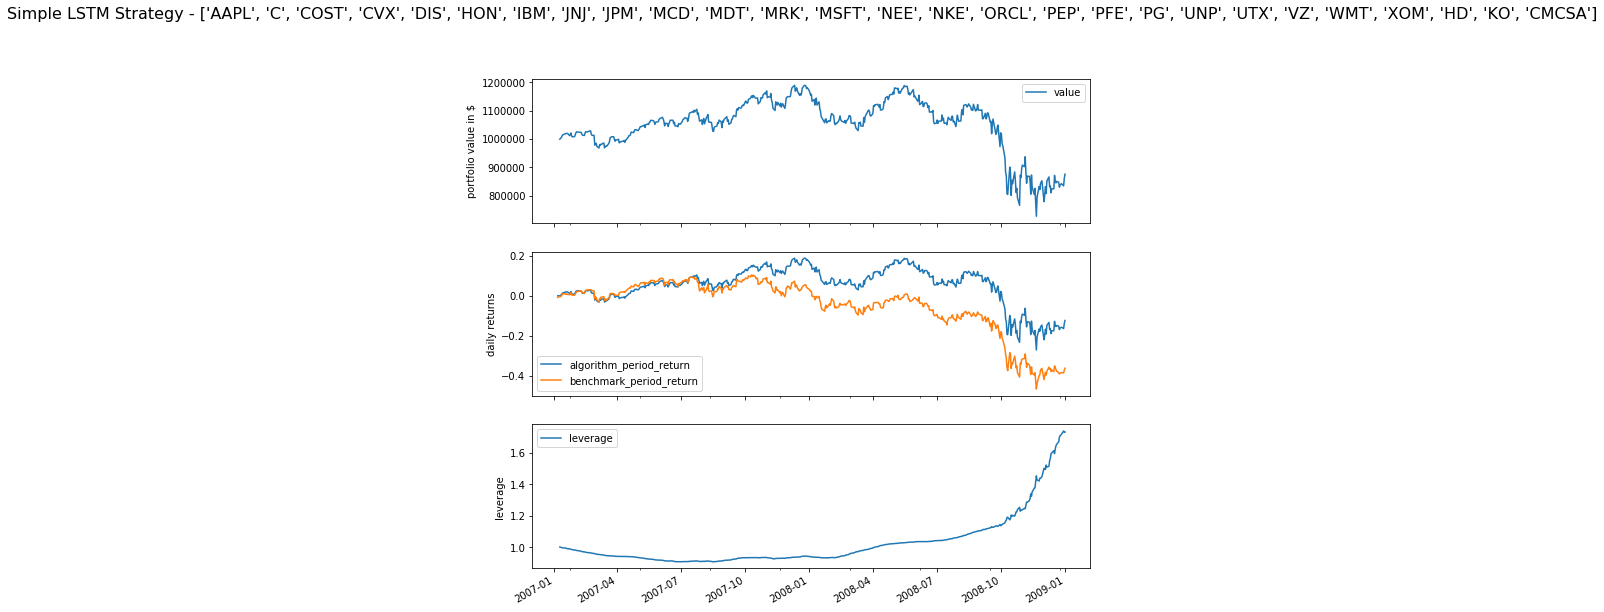

Final portfolio value (including cash): 876287.4$
                             POS       SPY  algo_volatility  \
2008-12-24 18:00:00+00:00  358.0  0.005803         0.308858   
2008-12-26 21:00:00+00:00  359.0  0.005770         0.308570   
2008-12-29 21:00:00+00:00  360.0 -0.002868         0.308321   
2008-12-30 21:00:00+00:00  360.0  0.023703         0.308864   
2008-12-31 21:00:00+00:00  360.0  0.014274         0.308778   

                           algorithm_period_return     alpha  \
2008-12-24 18:00:00+00:00                -0.161633  0.154153   
2008-12-26 21:00:00+00:00                -0.157359  0.153662   
2008-12-29 21:00:00+00:00                -0.164709  0.149835   
2008-12-30 21:00:00+00:00                -0.137863  0.155631   
2008-12-31 21:00:00+00:00                -0.123713  0.157156   

                           benchmark_period_return  benchmark_volatility  \
2008-12-24 18:00:00+00:00                -0.388297              0.314156   
2008-12-26 21:00:00+00:00         

In [14]:
from zipline.api import order, record, symbol, set_benchmark,symbols
import zipline
import matplotlib.pyplot as plt
from datetime import datetime
perf = zipline.run_algorithm(start=datetime(2007, 1, 5, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2008, 12, 31, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      capital_base=1000000,
                      handle_data=handle_data,
                      analyze = analyze,
                      data=panel)
import pickle
with open('model_LSTM.pickle','wb') as f:
    pickle.dump(perf,f)

Start date,2007-01-05
End date,2008-12-31
Total months,23
,Backtest
Annual return,-6.4%
Cumulative returns,-12.4%
Annual volatility,30.9%
Sharpe ratio,-0.06
Calmar ratio,-0.17
Stability,0.08
Max drawdown,-38.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.74,2007-12-24,2008-11-20,NaT,NaN
1,7.03,2007-07-23,2007-08-16,2007-09-19,43
2,5.91,2007-10-31,2007-11-12,2007-12-06,27
3,5.89,2007-02-21,2007-03-05,2007-04-25,46
4,3.04,2007-06-04,2007-06-26,2007-07-12,29


Stress Events,mean,min,max
Lehman,-0.10%,-7.23%,5.00%
Aug07,0.08%,-2.38%,2.23%
Mar08,0.28%,-1.58%,2.86%
Sept08,-0.33%,-7.23%,5.00%
Low Volatility Bull Market,0.05%,-3.41%,1.63%
GFC Crash,-0.03%,-9.06%,13.77%


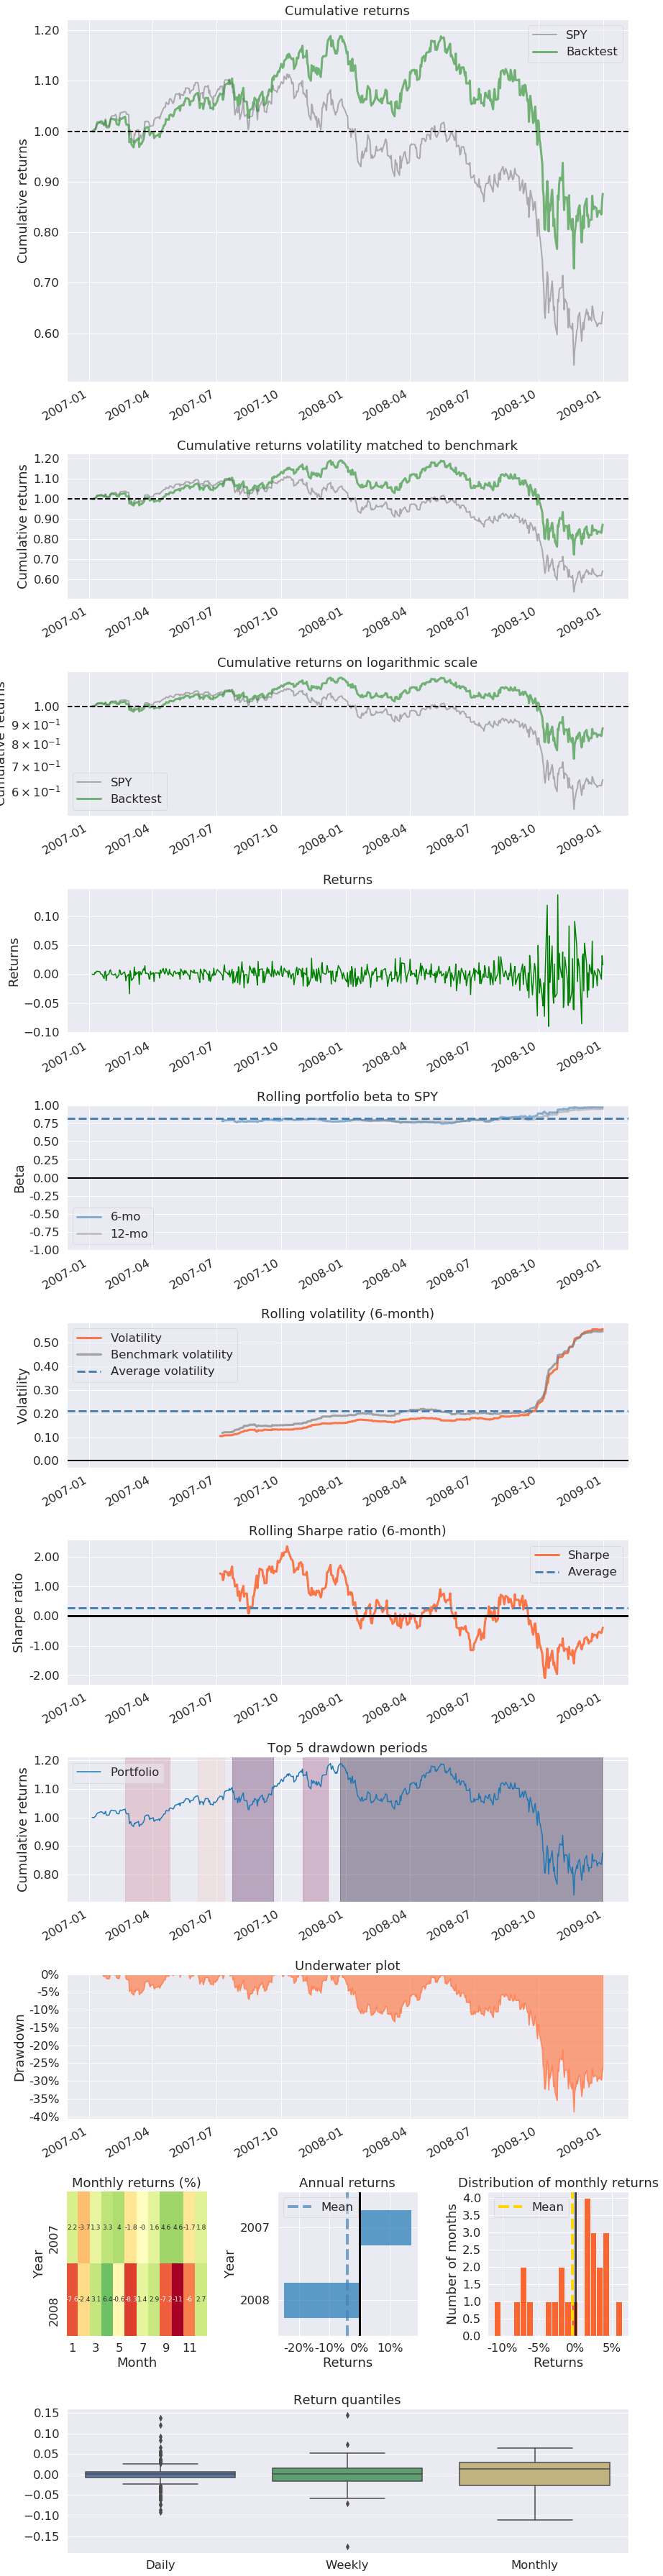

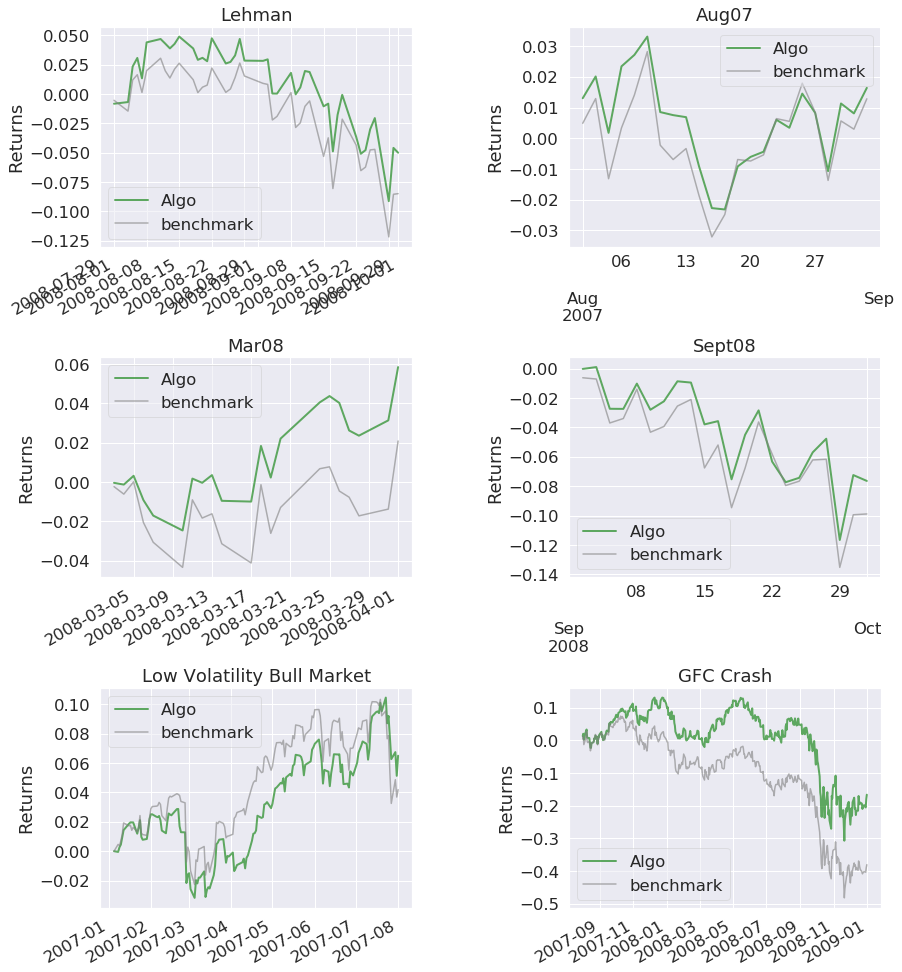

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipline
import warnings
import pyfolio as pf
LSTM_model3_results = pd.read_pickle('model_LSTM.pickle')
#print(LSTM_model3_results.columns)
SPY,returns, predict_returns = pf.utils.extract_rets_pos_txn_from_zipline(LSTM_model3_results)
algorithm = LSTM_model3_results.returns
SPY  =  LSTM_model3_results.SPY
pf.create_full_tear_sheet(algorithm,benchmark_rets=SPY)